In [1]:
import torch
import geoopt
from geoopt.optim import RiemannianSGD, RiemannianAdam
import matplotlib.pyplot as plt
from torchvision.transforms.functional import rotate

import numpy as np
from torch.func import grad

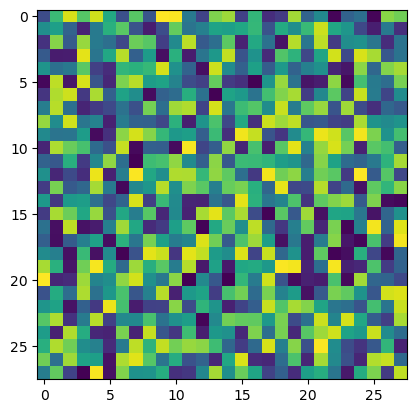

In [2]:
plt.imshow(torch.randint(0, 256, (1,28*28)).reshape(28,28))

In [3]:
W1_i = (torch.rand((64,784)).float() - 0.5)*2
b1_i = (torch.rand((64,1)).float() - 0.5)*2

W2_i = (torch.rand((10,64)).float() - 0.5)*2
b2_i = (torch.rand((10,1)).float() - 0.5)*2

In [4]:
mnist_vector = torch.randint(0, 256, (1,28,28)).float()/256
mnist_vector_rotated = rotate(img=mnist_vector, angle=90).reshape(784,1)
mnist_vector_rotated_180 = rotate(img=mnist_vector, angle=180).reshape(784,1)
mnist_vector_rotated_270 = rotate(img=mnist_vector, angle=270).reshape(784,1)
mnist_vector = mnist_vector.reshape(784,1)

def NN(x, thetas):
    W1, b1, W2, b2 = deflatten(thetas, get_shapes([W1_i, b1_i, W2_i,b2_i]))
    out = W2 @ torch.nn.LeakyReLU()(W1 @ x + b1) + b2
    return out

# Funzione che definisce la varietà: sfera unitaria centrata in 0
def g(thetas):
    NN1 = NN(mnist_vector, thetas)
    NN2 = NN(mnist_vector_rotated, thetas)
    Delta_NN = NN1 - NN2
    norm = Delta_NN.norm()**2
    return norm # sfera unitaria

# Gradiente di f
def dg(thetas):
    gradient = grad(g)(thetas)
    return gradient #+ 1e-5*(gradient.norm()==0)

def flatten(weights_list):
    flatten_weights = []
    for weight in weights_list:
        flatten_weights.append(weight.flatten())
        
    return np.concatenate(flatten_weights)

def deflatten(weights_flat, shapes):
    weigths_list = []
    shape_counter = 0
    for shape in shapes:
        weight = torch.Tensor(weights_flat[shape_counter: shape_counter + np.prod(shape)])
        shape_counter = shape_counter + np.prod(shape)
        
        weigths_list.append(weight.reshape(shape))
            
    return weigths_list

def get_shapes(weights_list):
    shapes = []
    for weight in weights_list:
        shapes.append(weight.shape)
    return(shapes)

# Classe LevelSetManifold già implementata sopra
class LevelSetManifold(geoopt.manifolds.Manifold):
    
    ndim = 1
    name = "Caste"
    
    def __init__(self, f, df, lr_proj = 1):
        super().__init__()
        self.f = f
        self.df = df
        self.lr_proj = lr_proj

    def _check_point_on_manifold(self, x, atol=1e-7, rtol=1e-7):
        return torch.abs(self.f(x)) < atol

    def _check_vector_on_tangent(self, x, u, atol=1e-7, rtol=1e-7):
        grad_f = self.df(x)
        return torch.abs(u @ grad_f).sum() < atol
    
    def projx(self,x):
        if self._check_point_on_manifold(x):
            return x
        for r in range(50):
            x = self.single_projx(x)
#             print("g: ", self.f(x))
#             print("dg: ", self.df(x).norm())
            if r == 49:
                print(f"Retraction applied {r + 1} times")
            if self._check_point_on_manifold(x):
                print(f"Retraction applied {r + 1} times")
                break
        return x
    
    def single_projx(self, x):
        grad_f = self.df(x)
        f_val = self.f(x)
        return x - self.lr_proj*(f_val / grad_f.norm()**2 * grad_f)

    def proju(self, x, u):
        grad_f = self.df(x)
        return u - (u @ grad_f) / grad_f.norm()**2 * grad_f

    def inner(self, x, u, v=None):
        if v is None:
            v = u
        return (u * v).sum()

    def expmap(self, x, u):
        return self.retr(x, u)

    def egrad2rgrad(self, x, u):
        return self.proju(x, u)

    def retr(self, x, u):
        x_new = x + u
        return self.projx(x_new)









g:  tensor(3063.6797, grad_fn=<PowBackward0>)
############ Landing phase #############
Retraction applied 19 times
0 g:  4.8756493953305835e-08
Landed :)



############## Training phase ################
Retraction applied 17 times
Epoch 1 Loss: 39.65838623046875 g(theta): 4e-08
Retraction applied 18 times
Epoch 2 Loss: 7.024617671966553 g(theta): 6e-08
Epoch 3 Loss: 0.0 g(theta): 6e-08
Epoch 4 Loss: 0.0 g(theta): 6e-08
Epoch 5 Loss: 0.0 g(theta): 6e-08
Epoch 6 Loss: 0.0 g(theta): 6e-08
Epoch 7 Loss: 0.0 g(theta): 6e-08
Epoch 8 Loss: 0.0 g(theta): 6e-08
Epoch 9 Loss: 0.0 g(theta): 6e-08
Epoch 10 Loss: 0.0 g(theta): 6e-08



Punto finale: Parameter on Caste manifold containing:
Parameter(ManifoldParameter([-0.8034, -0.1857,  0.1464,  ..., -0.6957,  0.1094,
                   -0.3439], requires_grad=True))
Appartiene alla varietà? tensor(True)


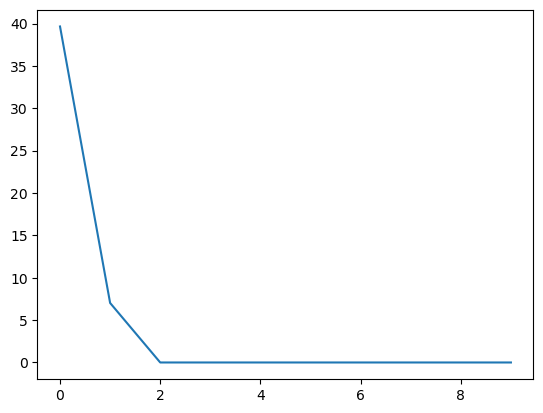

In [5]:
# Creiamo la varietà
manifold = LevelSetManifold(g, dg, 1)
# Test del parametro manifold

theta = flatten([W1_i, b1_i, W2_i, b2_i])
theta = geoopt.ManifoldParameter(theta , manifold=manifold)


# Proiettiamo il parametro iniziale sulla varietà
print("\n\n\n\n\n")
# print("99", "Primo theta: ",  theta.data)
print("g: ", g(theta))
print("############ Landing phase #############")
for i in range(10):
    theta.data = manifold.projx(theta.data)
    if i%5 == 0:
        print(i, "g: ", g(theta).item())

    if g(theta)< 1e-7:
        print("Landed :)")
        break
        
    
print("\n\n")

# Verifica che il parametro iniziale appartenga alla varietà
assert manifold._check_point_on_manifold(theta.data), "Il punto iniziale non è sulla varietà"

# Definiamo una loss function: minimizziamo la norma quadrata
def loss_fn(mnist_vector, theta):
    return torch.nn.CrossEntropyLoss()(NN(mnist_vector, theta).T, torch.Tensor([2]).long()  )  # Ad esempio, massimizzare la componente x[0]

# Ottimizzatore Riemanniano
optimizer = RiemannianSGD([theta], lr=0.005)

# Ciclo di ottimizzazione
g_during_train = []
loss_history = []
print("############## Training phase ################")
for epoch in range(10):
    optimizer.zero_grad()
    loss = loss_fn(mnist_vector, theta)
    loss.backward()
    optimizer.step()
    if epoch%1 == 0:
        print("Epoch",  epoch + 1, 
              "Loss:", loss.item(),
#               "theta:", theta.data[1].item(),
              "g(theta):", round(float(g(theta).data.numpy()),8))
    loss_history.append(loss.item())
    g_during_train.append(g(theta).data.numpy())
# plt.plot(g_during_train)
plt.plot(loss_history)
print("\n\n")

# Risultato finale
print("Punto finale:", theta)
print("Appartiene alla varietà?", manifold._check_point_on_manifold(theta))

In [6]:
# x = torch.randint(0, 256, (1,28,28)).float()
# x_90 = rotate(img=x, angle=90).reshape(784,1)
# x_180 = rotate(img=x, angle=180).reshape(784,1)
# x = x.reshape(784,1)

NN(mnist_vector,theta)

tensor([[ -5.4612],
        [ 31.1775],
        [ 54.3888],
        [-14.6865],
        [-16.5829],
        [-12.4351],
        [-21.4484],
        [-31.3337],
        [ 11.2241],
        [ 24.5159]], grad_fn=<AddBackward0>)

In [7]:
NN(mnist_vector_rotated, theta)

tensor([[ -5.4611],
        [ 31.1775],
        [ 54.3888],
        [-14.6865],
        [-16.5830],
        [-12.4351],
        [-21.4484],
        [-31.3336],
        [ 11.2242],
        [ 24.5160]], grad_fn=<AddBackward0>)

In [11]:
NN(mnist_vector_rotated_180, theta)

tensor([[-13.0654],
        [ 33.4997],
        [ 64.7408],
        [-30.1263],
        [-28.0009],
        [-11.3514],
        [-25.9165],
        [-26.8458],
        [ 16.4583],
        [ 11.0306]], grad_fn=<AddBackward0>)

In [12]:
NN(mnist_vector_rotated_270, theta)

tensor([[ 11.0358],
        [ 34.6899],
        [ 49.4026],
        [-21.6047],
        [-25.0090],
        [-16.8957],
        [-29.1625],
        [-62.2878],
        [-14.7283],
        [ 13.0199]], grad_fn=<AddBackward0>)

In [8]:
get_shapes([W1_i, b1_i, W2_i,b2_i])

[torch.Size([64, 784]),
 torch.Size([64, 1]),
 torch.Size([10, 64]),
 torch.Size([10, 1])]

In [9]:
W1, b1, W2, b2 = deflatten(theta, get_shapes([W1_i, b1_i, W2_i,b2_i]))
y = x.flatten()
y = y.reshape(784,1)
print(y.shape)
N0 = (W1 @ y + b1)
print(N0.shape)
N1 =  torch.nn.LeakyReLU()(N0)
N2 = W2 @ N1 + b2
print(N2.shape)

NameError: name 'x' is not defined

In [ ]:
def NN(x, thetas):
    W1, b1, W2, b2 = deflatten(thetas, get_shapes([W1_i, b1_i, W2_i,b2_i]))
    out = W2 @ torch.nn.LeakyReLU()(W1 @ x + b1) + b2
    return out